In [82]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [85]:
def calculate_sma(df, period):
    return df['Close'].rolling(window=period).mean()

def calculate_ema(df, period):
    return df['Close'].ewm(span=period, adjust=False).mean()

def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    macd_line = df['Close'].ewm(span=short_period, adjust=False).mean() - df['Close'].ewm(span=long_period, adjust=False).mean()
    macd_signal = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, macd_signal

def calculate_roc(df, period=14):
    return ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period)) * 100

def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            obv.append(obv[-1] + df['Volume'][i])
        elif df['Close'][i] < df['Close'][i-1]:
            obv.append(obv[-1] - df['Volume'][i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df.index)

def calculate_mfi(df, period=14):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    raw_money_flow = typical_price * df['Volume']
    positive_flow = []
    negative_flow = []
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(raw_money_flow[i-1])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(raw_money_flow[i-1])
            positive_flow.append(0)
        else:
            positive_flow.append(0)
            negative_flow.append(0)
            
    positive_mf = pd.Series(positive_flow).rolling(window=period).sum()
    negative_mf = pd.Series(negative_flow).rolling(window=period).sum()
    mfi = 100 - (100 / (1 + positive_mf / negative_mf))
    return mfi

def calculate_standard_deviation(df, period=20):
    return df['Close'].rolling(window=period).std()

def calculate_adx(df, period=14):
    df = df.copy()
    df['TR'] = np.maximum((df['High'] - df['Low']), 
                          np.maximum(abs(df['High'] - df['Close'].shift(1)), 
                                     abs(df['Low'] - df['Close'].shift(1))))
    
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    
    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()
    
    df['+DI14'] = 100 * (df['+DM14'] / df['TR14'])
    df['-DI14'] = 100 * (df['-DM14'] / df['TR14'])
    df['DX'] = 100 * abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])
    
    df['ADX'] = df['DX'].rolling(window=period).mean()
    
    return df['ADX']

In [86]:

# Calculate and add the On-Balance Volume (OBV) to the DataFrame
data['OBV'] = calculate_obv(data)

# Calculate and add the Standard Deviation to the DataFrame to measure stock volatility
data['Standard_Deviation'] = calculate_standard_deviation(data)

# ADX
data['ADX'] = calculate_adx(data)

data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_100'] = data['Close'].rolling(window=100).mean()
data['SMA_200'] = data['Close'].rolling(window=100).mean()
# Exponential Moving Average
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Bollinger Bands
data['Middle_BB'] = data['Close'].rolling(window=20).mean()
data['Upper_BB'] = data['Middle_BB'] + 2*data['Close'].rolling(window=20).std()
data['Lower_BB'] = data['Middle_BB'] - 2*data['Close'].rolling(window=20).std()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
# Volume Changes
data['Volume_Change'] = data['Volume'].diff()

# Price Rate of Change
data['Price_ROC'] = data['Close'].pct_change(periods=5)
#Stochastic Oscillator
k_window=14
d_window=3
low_min = data['Low'].rolling(window=k_window).min()
high_max = data['High'].rolling(window=k_window).max()
data['%K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
# Calculate %D
data['%D'] = data['%K'].rolling(window=d_window).mean()

In [87]:
data['Return'] = data['Close'].pct_change()
data['Target'] = (data['Return']>0).astype(int)

In [88]:
data.dropna(inplace = True)
data = data.replace([np.inf, -np.inf], np.nan).dropna()

In [89]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'OBV',
       'Standard_Deviation', 'ADX', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100',
       'SMA_200', 'EMA_10', 'EMA_20', 'EMA_50', 'Middle_BB', 'Upper_BB',
       'Lower_BB', 'RSI', 'MACD', 'Signal_Line', 'Volume_Change', 'Price_ROC',
       '%K', '%D', 'Return']

In [90]:
scaler = MinMaxScaler(feature_range=(0,1))
data[features] = scaler.fit_transform(data[features])

In [91]:
X = data[features]
y = data['Target']

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

In [102]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

accuracy, precision, f1, auc

(0.9981492905613819,
 0.9962593516209476,
 0.9981261711430355,
 0.9999847741550416)

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Initialize Logistic Regression model
log_reg_model = LogisticRegression()

# Fit the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1])

accuracy, precision, f1, auc

(0.8834053053670574,
 0.8648325358851675,
 0.8844036697247707,
 0.9560323275140153)

In [99]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Initialize Support Vector Machine classifier
svm_model = SVC(probability=True)  # Enable probability estimates for AUC calculation

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

accuracy, precision, f1, auc

(0.8908081431215299, 0.8737980769230769, 0.891477621091355, 0.9610149852766078)

In [100]:
# Code for evaluating train metrics for SVM model
# Assuming the SVM model (svm_model) is already trained with X_train and y_train

# Make predictions on the training data
y_train_pred = svm_model.predict(X_train)

# Calculate metrics on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, svm_model.predict_proba(X_train)[:, 1])

# Print the training metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"F1 Score: {train_f1}")
print(f"AUC Score: {train_auc}")

Training Metrics:
Accuracy: 0.8926493918561608
Precision: 0.8946248004257584
F1 Score: 0.8922505307855627
AUC Score: 0.9640570690770405


In [103]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Initialize Extra Trees classifier
etc_model = ExtraTreesClassifier()

# Fit the model on the training data
etc_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = etc_model.predict(X_test)

# Calculate metrics
etc_accuracy = accuracy_score(y_test, y_pred)
etc_precision = precision_score(y_test, y_pred)
etc_f1 = f1_score(y_test, y_pred)
etc_auc = roc_auc_score(y_test, etc_model.predict_proba(X_test)[:, 1])

etc_accuracy, etc_precision, etc_f1, etc_auc


(0.9204194941394201,
 0.9125615763546798,
 0.9199255121042831,
 0.9773538395013232)

In [110]:
import backtrader as bt
import yfinance as yf
import numpy as np

# Load historical data for TGT from Yahoo Finance
start_date = '2020-01-01'  # Replace with your actual start date
end_date = '2022-01-01'    # Replace with your actual end date
data_tgt = yf.download('RHI', start=start_date, end=end_date)



# Set random seed
np.random.seed(903948185)
num_rows = len(data_tgt)  # Replace with len(data_tgt) in actual code

# Generate y_pred with the same length as the data_tgt rows
y_pred = np.random.choice([0, 1], size=num_rows)

# Define the trading strategy based on random predictions
class MLBasedStrategy(bt.Strategy):
    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter < len(y_pred):
            # Buy if the prediction is 1 (positive return), else sell
            if y_pred[self.counter] == 0:
                self.buy()
            else:
                self.close()  # Close any existing position
        self.counter += 1

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Set initial cash
cerebro.broker.setcash(1000000)  # $1,000,000

# Set commission
cerebro.broker.setcommission(commission=0.05)

# Add strategy
cerebro.addstrategy(MLBasedStrategy)

# Convert the data to a format that Backtrader can use and add data feed
data_feed = bt.feeds.PandasData(dataname=data_tgt)
cerebro.adddata(data_feed)

# Add analyzers for Sharpe Ratio and trade statistics
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

# Run the strategy
results = cerebro.run()

# Extract results
final_portfolio_value = cerebro.broker.getvalue()
pnl = final_portfolio_value - cerebro.broker.startingcash
sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
trade_stats = results[0].analyzers.trade_analyzer.get_analysis()

# Print results
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Profit / Loss: {pnl}")
print(f"Sharpe Ratio: {sharpe_ratio['sharperatio'] if 'sharperatio' in sharpe_ratio else 'N/A'}")
print(f"Trade Statistics: {trade_stats}")



[*********************100%***********************]  1 of 1 completed
Final Portfolio Value: 998192.2664510708
Profit / Loss: -1807.7335489292163
Sharpe Ratio: -39.545132214982964
Trade Statistics: AutoOrderedDict([('total', AutoOrderedDict([('total', 131), ('open', 0), ('closed', 131)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 1)])), ('lost', AutoOrderedDict([('current', 77), ('longest', 77)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 44.489948272705156), ('average', 0.3396179257458409)])), ('net', AutoOrderedDict([('total', -1807.7335489273066), ('average', -13.799492739903105)]))])), ('won', AutoOrderedDict([('total', 1), ('pnl', AutoOrderedDict([('total', 1.4229995727539055), ('average', 1.4229995727539055), ('max', 1.4229995727539055)]))])), ('lost', AutoOrderedDict([('total', 130), ('pnl', AutoOrderedDict([('total', -1809.1565485000606), ('average', -13.916588834615851), ('max', -68.19051399230955)]))])), ('long', 

In [113]:
# import backtrader as bt
# import yfinance as yf
# import numpy as np
# import pyfolio as pf
# import quantstats
# import matplotlib.pyplot as plt

# # Load historical data for RHI from Yahoo Finance
# start_date = '2020-01-01'
# end_date = '2022-01-01'
# data_tgt = yf.download('RHI', start=start_date, end=end_date)

# # Set random seed and generate predictions
# np.random.seed(903948185)
# y_pred = np.random.choice([0, 1], size=len(data_tgt))

# # Define the trading strategy based on random predictions
# class MLBasedStrategy(bt.Strategy):
#     def __init__(self):
#         self.counter = 0

#     def next(self):
#         if self.counter < len(y_pred):
#             if y_pred[self.counter] == 0:
#                 self.buy()
#             else:
#                 self.close()
#         self.counter += 1

# # Initialize Cerebro engine
# cerebro = bt.Cerebro()

# # Set initial cash and commission
# cerebro.broker.setcash(1000000)
# cerebro.broker.setcommission(commission=0.05)

# # Add strategy
# cerebro.addstrategy(MLBasedStrategy)

# # Add data feed
# data_feed = bt.feeds.PandasData(dataname=data_tgt)
# cerebro.adddata(data_feed)

# # Add analyzers
# cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
# cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

# # Run the strategy
# results = cerebro.run()




# # Extract results
# final_portfolio_value = cerebro.broker.getvalue()
# pnl = final_portfolio_value - cerebro.broker.startingcash
# sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
# trade_stats = results[0].analyzers.trade_analyzer.get_analysis()

# # Print basic results
# print(f"Final Portfolio Value: {final_portfolio_value}")
# print(f"Profit / Loss: {pnl}")
# print(f"Sharpe Ratio: {sharpe_ratio['sharperatio'] if 'sharperatio' in sharpe_ratio else 'N/A'}")
# print(f"Trade Statistics: {trade_stats}")

# # # PyFolio analysis
# pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
# returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
# pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, live_start_date=start_date)

# # Quantstats report
# quantstats.reports.html(returns, title="ML Based Strategy Report", output='quantstats_report.html')


[*********************100%***********************]  1 of 1 completed


AttributeError: 'BackBroker' object has no attribute 'get_value_history'

[*********************100%***********************]  1 of 1 completed
Error creating PyFolio tear sheet: single positional indexer is out-of-bounds

C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\

                           Strategy
-------------------------  ----------
Start Period               2020-01-02
End Period                 2021-12-31
Risk-Free Rate             0.0%
Time in Market             76.0%

Cumulative Return          -0.18%
CAGR﹪                     -0.06%

Sharpe                     -12.8
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -12.36
Sortino                    -10.08
Smart Sortino              -9.73
Sortino/√2                 -7.13
Smart Sortino/√2           -6.88
Omega                      0.03

Max Drawdown               -0.18%
Longest DD Days            725
Volatility (ann.)          0.01%
Calmar                     -0.35
Skew                       -2.0
Kurtosis                   7.99

Expected Daily %           -0.0%
Expected Monthly %         -0.01%
Expected Yearly %          -0.09%
Kelly Criterion            -182.11%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.0%
Expected Shortfall (cVaR)  -0.0%

Max Consecutive Win

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-07,2021-12-31,2021-12-31,725,-0.180773,-0.176187


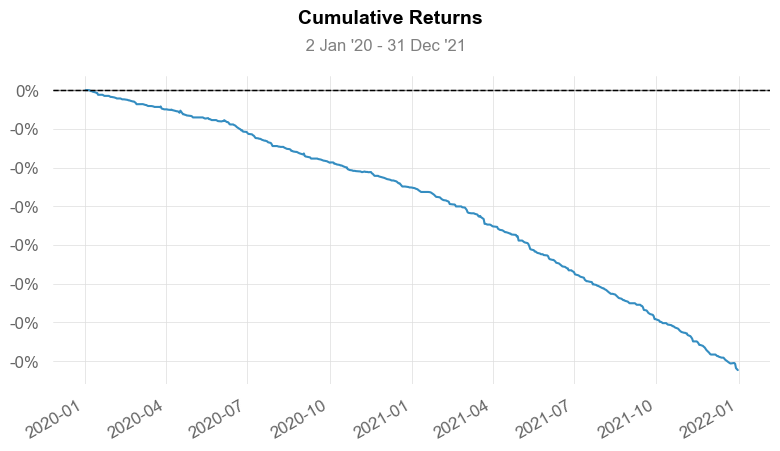

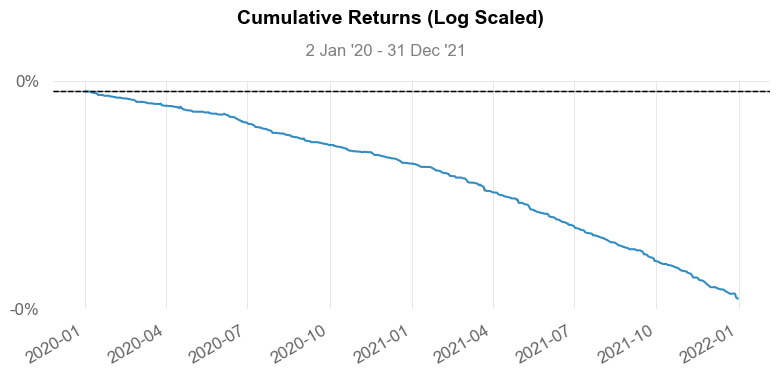

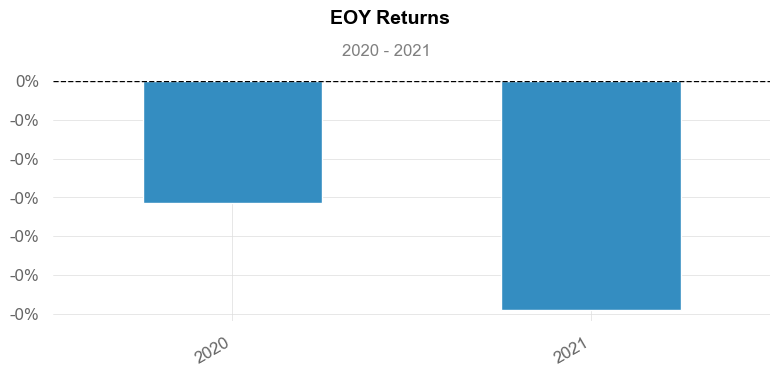

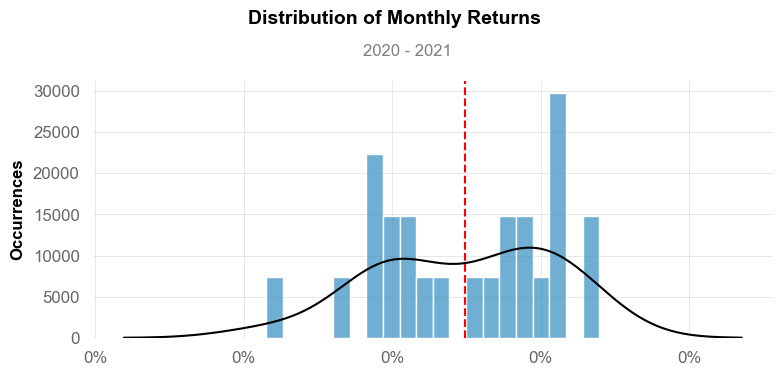

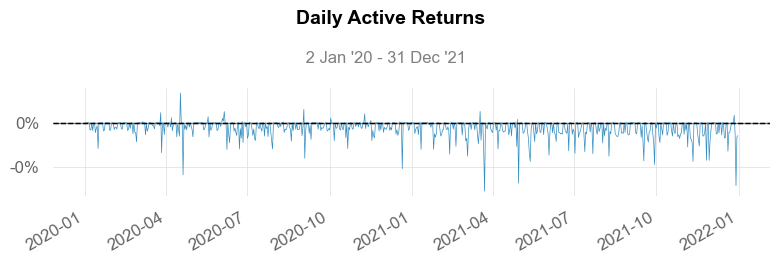

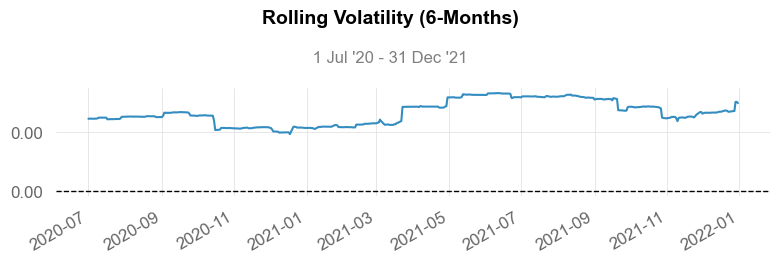

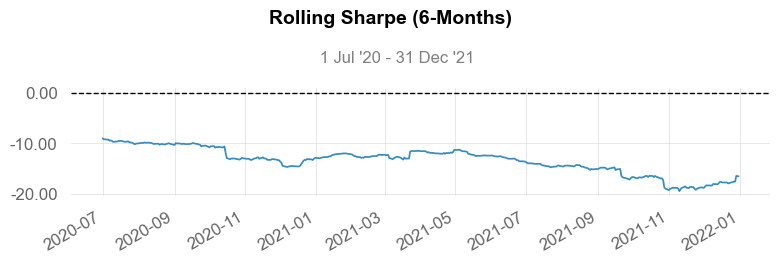

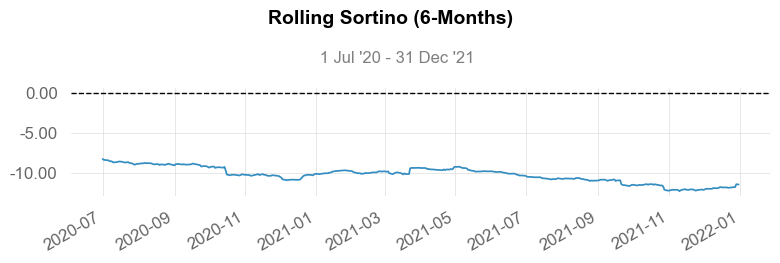

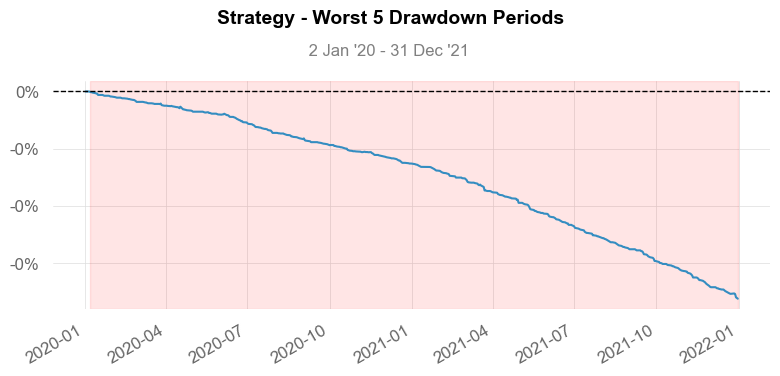

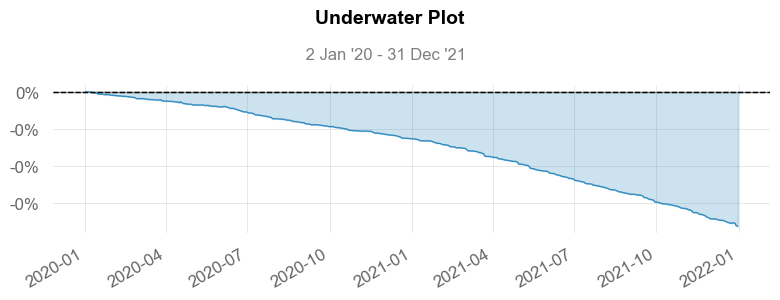

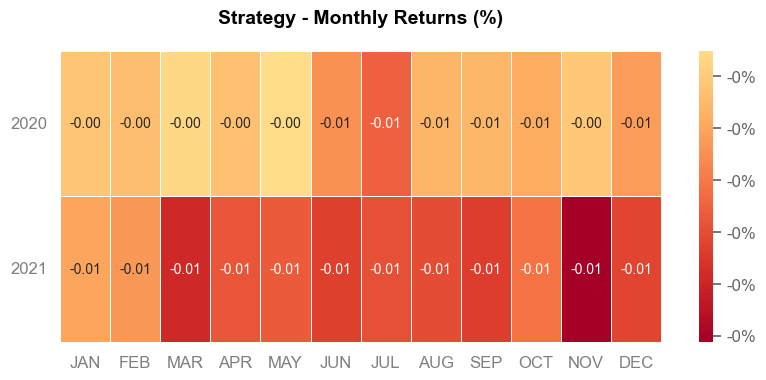

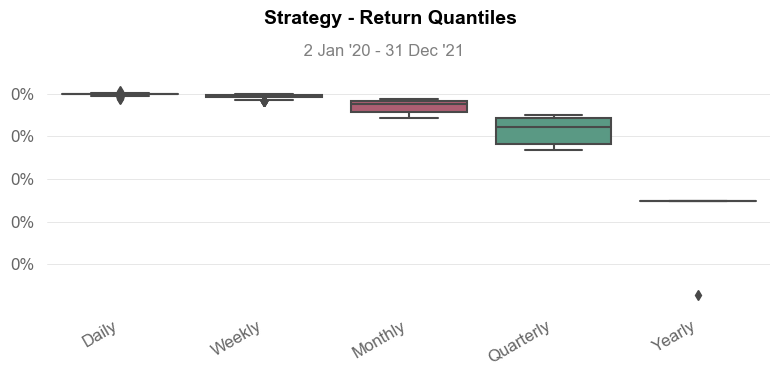

In [115]:
import backtrader as bt
import yfinance as yf
import numpy as np
import pyfolio as pf
import quantstats
import matplotlib.pyplot as plt
import pandas as pd

# Load historical data for RHI from Yahoo Finance
start_date = '2020-01-01'
end_date = '2022-01-01'
data_tgt = yf.download('RHI', start=start_date, end=end_date)

# Set random seed and generate predictions
np.random.seed(903948185)
y_pred = np.random.choice([0, 1], size=len(data_tgt))

# Define the trading strategy based on random predictions
class MLBasedStrategy(bt.Strategy):
    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter < len(y_pred):
            if y_pred[self.counter] == 0:
                self.buy()
            else:
                self.close()
        self.counter += 1

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Set initial cash and commission
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(commission=0.05)

# Add strategy
cerebro.addstrategy(MLBasedStrategy)

# Add data feed
data_feed = bt.feeds.PandasData(dataname=data_tgt)
cerebro.adddata(data_feed)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Run the strategy
results = cerebro.run()

# Extract results for PyFolio
strategy = results[0]
pyfoliozer = strategy.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# Handle potential empty data
if returns.empty:
    print("No returns data available for PyFolio.")
else:
    # Ensure the returns are a pandas Series
    returns = pd.Series(returns)

    # PyFolio report
    try:
        pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, live_start_date=start_date)
    except Exception as e:
        print(f"Error creating PyFolio tear sheet: {e}")

# Quantstats report
if returns.empty:
    print("No returns data available for quantstats.")
else:
    try:
        quantstats.reports.html(returns, title="ML Based Strategy Report", output='quantstats_report.html')
        # Optionally display the Quantstats report in a Jupyter notebook
        quantstats.reports.full(returns)
    except Exception as e:
        print(f"Error creating quantstats report: {e}")


[*********************100%***********************]  1 of 1 completed


C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\spsk9\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\

Error creating PyFolio tear sheet: single positional indexer is out-of-bounds


                           Strategy
-------------------------  ----------
Start Period               2020-01-02
End Period                 2021-12-31
Risk-Free Rate             0.0%
Time in Market             76.0%

Cumulative Return          -0.18%
CAGR﹪                     -0.06%

Sharpe                     -14.08
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -12.22
Sortino                    -10.71
Smart Sortino              -9.29
Sortino/√2                 -7.57
Smart Sortino/√2           -6.57
Omega                      0.03

Max Drawdown               -0.18%
Longest DD Days            729
Volatility (ann.)          0.01%
Calmar                     -0.35
Skew                       -1.05
Kurtosis                   4.04

Expected Daily %           -0.0%
Expected Monthly %         -0.01%
Expected Yearly %          -0.09%
Kelly Criterion            -191.21%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.0%
Expected Shortfall (cVaR)  -0.0%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-03,2021-12-31,2021-12-31,729,-0.181523,-0.179516


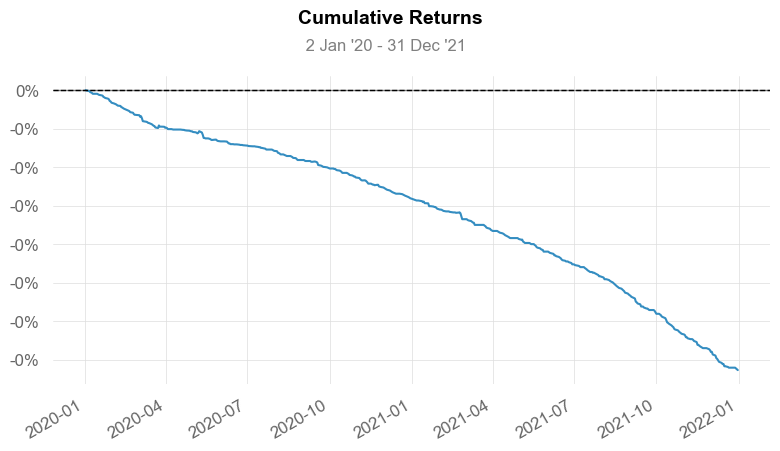

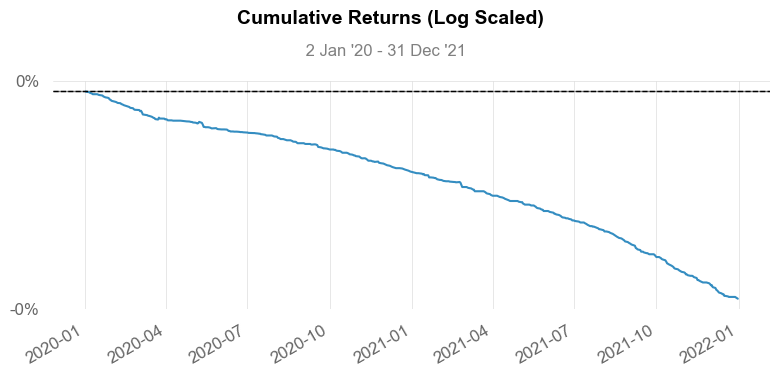

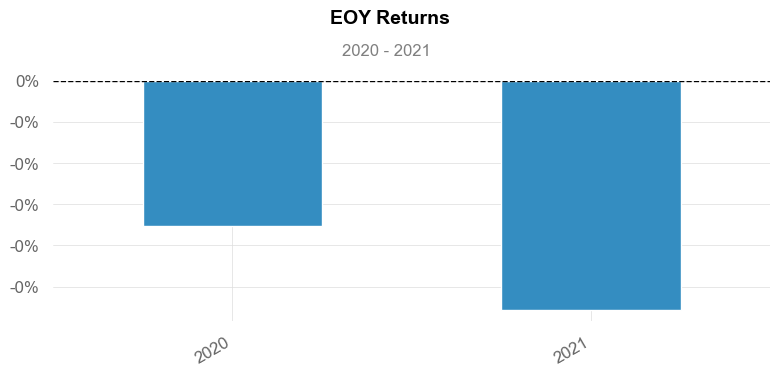

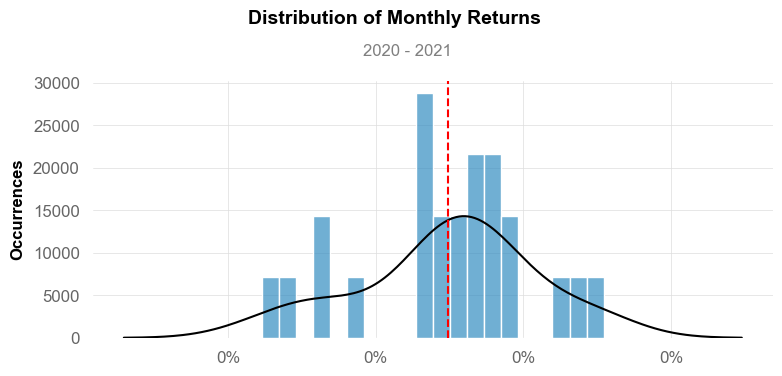

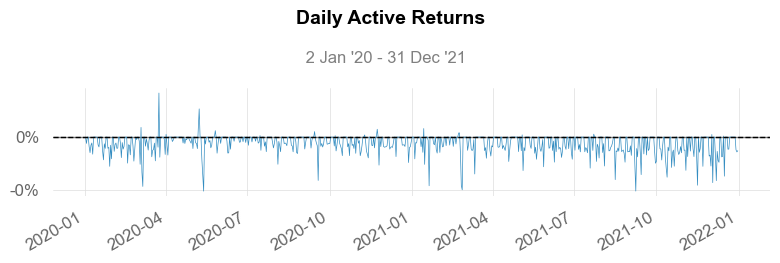

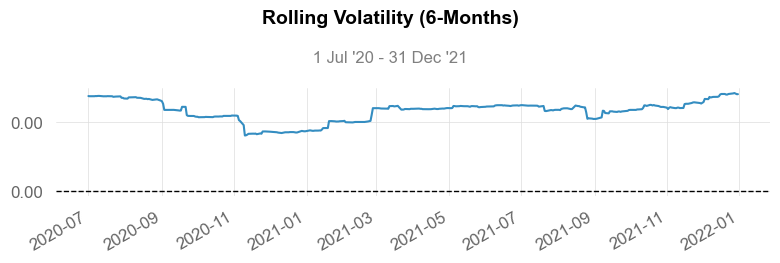

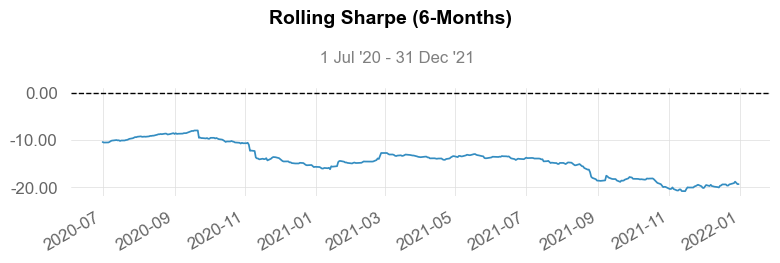

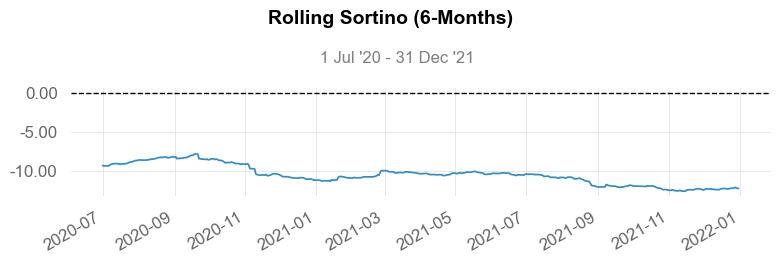

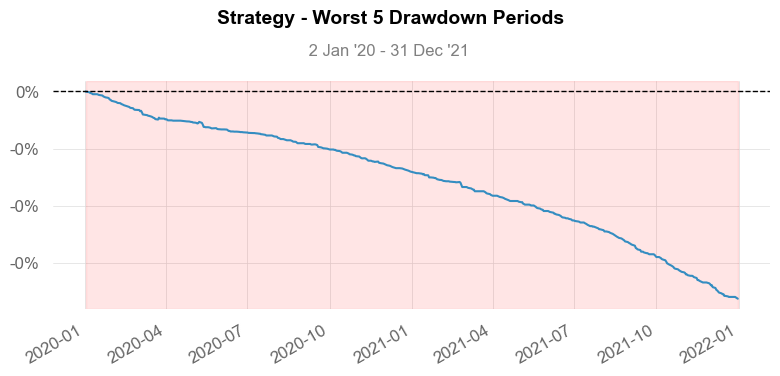

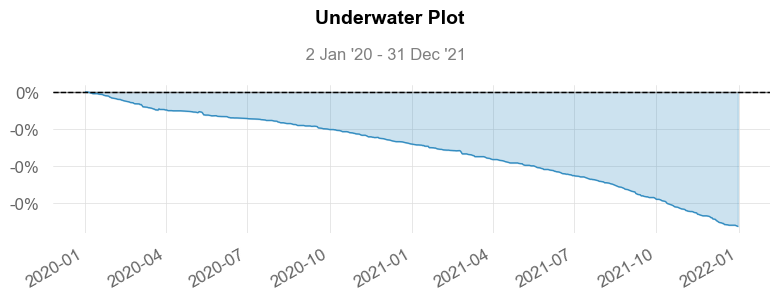

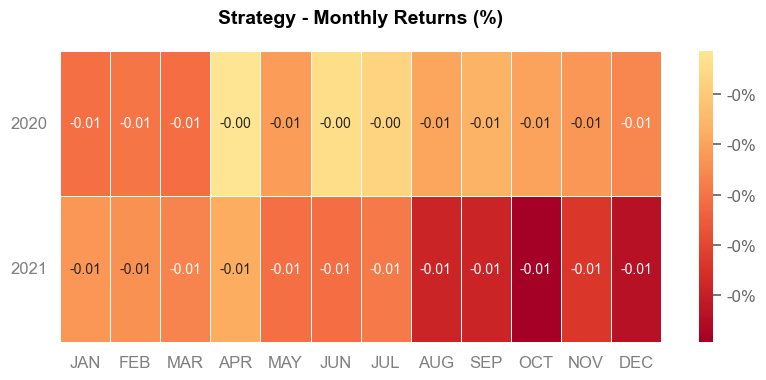

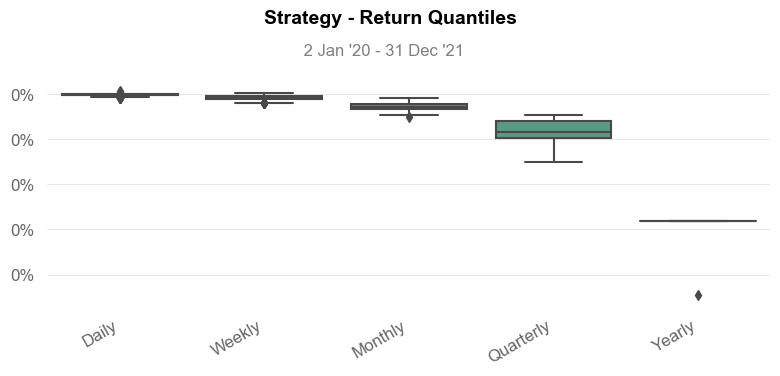

In [117]:
import backtrader as bt
import yfinance as yf
import numpy as np
import pyfolio as pf
import quantstats
import matplotlib.pyplot as plt
import pandas as pd

# Load historical data for RHI from Yahoo Finance
start_date = '2020-01-01'
end_date = '2022-01-01'
data_tgt = yf.download('RHI', start=start_date, end=end_date)

# Set random seed and generate predictions
np.random.seed(903948185)
y_pred = np.random.choice([0, 1], size=len(data_tgt))

# Define the trading strategy based on random predictions
class MLBasedStrategy(bt.Strategy):
    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter < len(y_pred):
            if y_pred[self.counter] == 1:
                self.buy()
            else:
                self.close()
        self.counter += 1

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Set initial cash and commission
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(commission=0.05)

# Add strategy
cerebro.addstrategy(MLBasedStrategy)

# Add data feed
data_feed = bt.feeds.PandasData(dataname=data_tgt)
cerebro.adddata(data_feed)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Run the strategy
results = cerebro.run()

# Extract results for PyFolio
strategy = results[0]
pyfoliozer = strategy.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# Ensure the returns are a pandas Series
returns = pd.Series(returns)

# Check if returns, positions, or transactions are empty
if returns.empty or positions.empty or transactions.empty:
    print("One or more of the required data structures (returns, positions, transactions) are empty.")
else:
    # Attempt to create PyFolio tear sheet
    try:
        pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, live_start_date=start_date)
    except Exception as e:
        print(f"Error creating PyFolio tear sheet: {e}")

# Quantstats report
if returns.empty:
    print("No returns data available for quantstats.")
else:
    try:
        quantstats.reports.html(returns, title="ML Based Strategy Report", output='quantstats_report.html')
        # Optionally display the Quantstats report in a Jupyter notebook
        quantstats.reports.full(returns)
    except Exception as e:
        print(f"Error creating quantstats report: {e}")


In [118]:
import pandas as pd
df = pd.read_csv("Metrics_Big_Universe.csv")

In [119]:
df.head()

,Unnamed: 0,ticker,model,accuracy,precision,F1,AUC
0,0,DAL.csv,Suuport Vector Machine,0.872832,0.840376,0.890547,0.951640
1,1,DAL.csv,Extra Trees Classifier,0.907514,0.915344,0.915344,0.969214
2,2,DE.csv,Suuport Vector Machine,0.791908,0.819767,0.796610,0.891953
3,3,DE.csv,Extra Trees Classifier,0.893064,0.905028,0.897507,0.958758
4,4,DFS.csv,Suuport Vector Machine,0.803468,0.752525,0.814208,0.915296


In [132]:
# Filter by model and sort by accuracy
filtered_df = df.sort_values(by='accuracy', ascending=False)
filtered_df[filtered_df['model']== "Suuport Vector Machine"]
filtered_df['ticker'].head(30)

743    ZION.csv
661     UPS.csv
627     TRV.csv
85      EXC.csv
247     IRM.csv
551    SBUX.csv
679     VMC.csv
275     KEY.csv
113    FITB.csv
475     PHM.csv
303     LEG.csv
87     EXPD.csv
277     KHC.csv
491     PPG.csv
145     GIS.csv
55      EIX.csv
257    JBHT.csv
273       K.csv
425     NSC.csv
321     LOW.csv
655     UNH.csv
103     FDX.csv
595     SYF.csv
173    HBAN.csv
669       V.csv
651     UHS.csv
21     DISH.csv
463     PEP.csv
389     MTB.csv
279     KIM.csv
Name: ticker, dtype: object